In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation
from keras.losses import mean_absolute_error

from lib import LSTM_model

Using TensorFlow backend.


In [2]:
plt.ion()

In [3]:
plt.rcParams["figure.figsize"] = (18,9)

#### Data with many null values

In [4]:
bs_df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv')

### First 20 instances

In [5]:
df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv',
                 dtype={
                     'Timestamp': np.int64,
                     'Open': np.float64,
                     'High': np.float64,
                     'Low': np.float64,
                     'Close': np.float64,
                     'Volume_(BTC)': np.float64,
                     'Volume_(Currency)': np.float64,
                     'Weighted_Price': np.float64
                 }).sort_values(by=['Timestamp'])

In [6]:
df = df.set_index('Timestamp')

# Ensure that there exists an instance for each minute
df = df.reindex(range(df.index[0], df.index[-1], 60), fill_value=np.nan)

df.reset_index(level=0, inplace=True)

df['Timestamp'] = df['Timestamp'].apply(lambda t: datetime.utcfromtimestamp(t))

df.head(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,2014-12-01 05:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-01 05:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-01 05:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-01 05:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-12-01 05:38:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014-12-01 05:39:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014-12-01 05:40:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
8,2014-12-01 05:41:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014-12-01 05:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Step at 1minute granularity

### First 20 instances after the interpolation

In [7]:
df.interpolate(inplace=True)
df.head(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
1,2014-12-01 05:34:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
2,2014-12-01 05:35:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
3,2014-12-01 05:36:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
4,2014-12-01 05:37:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
5,2014-12-01 05:38:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
6,2014-12-01 05:39:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
7,2014-12-01 05:40:00,300.000000,300.000000,300.000000,300.000000,0.01,3.000000,300.000000
8,2014-12-01 05:41:00,301.590909,301.590909,301.590909,301.590909,0.01,3.015909,301.590909
9,2014-12-01 05:42:00,303.181818,303.181818,303.181818,303.181818,0.01,3.031818,303.181818


Number of instances

In [8]:
len(df)

2074707

Text(0, 0.5, 'Mean Price ($)')

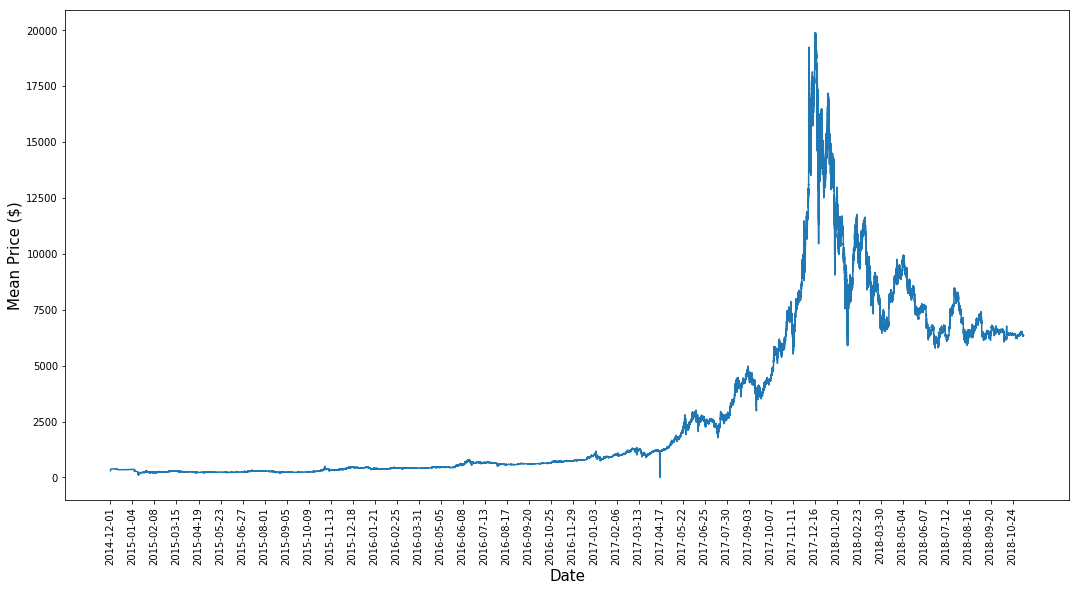

In [9]:
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
ts = df['Timestamp'].tolist()[::50000]
xticks = (t.strftime('%Y-%m-%d') for t in ts)
plt.xticks(range(0,df.shape[0],50000),xticks,rotation=90)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean Price ($)',fontsize=15)

### Map Data to Day granularity

In [10]:
df['Date'] = df['Timestamp'].apply(lambda t: t.date())
daily_info = df.groupby('Date').agg({
    'Open': lambda opens: opens.iloc[0],     # Opening value of the day
    'Close': lambda closes: closes.iloc[-1], # Closing value of the day
    'Low' : np.min,                          # Lowest value of the day
    'High': np.max,                          # Highest value of the day
    'Volume_(BTC)': np.sum                   # Sum of the volumes of the minutes in the day
}).reset_index(level=0)
daily_info['Mean'] = (daily_info['High'] + daily_info['Close']) / 2
daily_info.head(20)

,Date,Open,Close,Low,High,Volume_(BTC),Mean
0,2014-12-01,300.000000,375.300221,300.000000,375.300221,21.873404,375.300221
1,2014-12-02,375.305372,377.958639,375.305372,378.000000,1941.398508,377.979319
2,2014-12-03,377.958464,377.667052,377.010000,378.000000,169.819855,377.833526
3,2014-12-04,377.661850,377.516951,377.100000,377.661850,15.942718,377.589400
4,2014-12-05,377.517264,377.968047,377.517264,377.968047,19.541246,377.968047
5,2014-12-06,377.968361,377.026909,377.026909,378.000000,69.366556,377.513455
6,2014-12-07,377.029428,375.979636,375.979636,377.029428,179.692800,376.504532
7,2014-12-08,375.985646,376.261203,375.000000,376.270654,289.471801,376.265929
8,2014-12-09,376.284210,395.789505,376.274764,395.790466,182.990802,395.789985
9,2014-12-10,395.804021,368.564913,360.500000,398.000000,27.285516,383.282456


In [11]:
len(daily_info) # Number of days for which data is present or interpolated

1441

## Observations

### Evaluating Time Series Forecasting

In time series forecasting we have to choose the input and the output of the model. We can choose for example to predict $x_{t + 1}$ at a given time $t$ by giving in input to the model $x_t$ or giving in input $(x_{t-k}, x_{t - k + 1},...,x_{t})$ where $k$ is the window size, i.e. how much of the past the predictor can observe. Both cases are called *One-Step Ahead* Forecasting.

This can be useful in some cases, such as weather forecasting. In the case of trading though, we would like to predict far in the future. This can be done by iteratively letting the model predict the next values based *not* on the actual values of the window but on the previously predicted values i.e. given in input $(\hat x_{t-k}, \hat x_{t - k + 1},..., \hat x_{t})$. [[1]](https://github.com/kmsravindra/ML-AI-experiments/blob/master/AI/LSTM-time_series/LSTM%20-%20Sine%20wave%20predictor.ipynb) [[2]](https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f)

We must be careful on how we evaluate our model since what can happen is that we feed the network the actual data $(x_{t-k}, x_{t - k + 1},...,x_{t})$ for multiple values of $t$ producing the predicted values $\hat x_{t+1} \approx x_t, \hat x_{t+2} \approx x_{t+1}, \hat x_{t+3} \approx x_{t+2}, \hat x_{t+4} \approx x_{t+3}$ (similar to the *Persistence Model*) which produces a good result in terms of *Mean Absolute Error* (since the data has some inertia in fluctuatng) but not really useful given that at each timestep the model can see the previous *actual* data and thus does not depend by previous wrong predictions. [[3]](https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning/) [[4]](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb)

![lag](images/lag.png)

Alternatively we can perform a *Multi Step* Forecast i.e. letting the model predict the next $m$ values $x_{t+1}, ..., x_{t+m}$

### Data Preprocessing

Another issue we must consider is how to preprocess the data. We cannot normalize it over the full time period since given the spike of the BTC price in December 2017 a good portion of the data will be normalized close to 0.

A good way would be normalize the data in the time window, i.e. by representing each datapoint in the window as a ratio (positive or negative) of increase/decrease in value with respect to the first data point of the window. In this case the data points will be values in the range $[-1, 1]$ thus a good activation function would be $tanh$. [Function normalize_windows [5]](https://towardsdatascience.com/using-recurrent-neural-networks-to-predict-bitcoin-btc-prices-c4ff70f9f3e4#2dd7)

Another way can be differencing the data which means mapping point $x_t$ to $x_t' = x_t - x_{t-1}$

These processes are called making the data *stationary*, the data does not depend by trends.

The windows can either overlap or not [[6]](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/)

## Model

### Transform each window

Each window is "normalized" thus representing each value as percentage in increase or decrease of the first value in the window

$$
    w' = \frac{w}{w_0} - 1
$$

In [12]:
IN_TIMESTEPS  = 15
OUT_TIMESTEPS = 1
TRAIN_RATIO = 0.7
X_cols = ["Open", "Close", "Mean"]
Y_cols = ["Mean"]

EPOCHS = 1000
BATCH_SZ = 256

In [13]:
def build_lstm_nn(timesteps, out_size, input_shape):
    return Sequential([
        LSTM(
            out_size,
            input_shape=(timesteps, input_shape)
    )])

model = LSTM_model(
    in_timesteps=IN_TIMESTEPS, out_timesteps=OUT_TIMESTEPS,
    x_cols=X_cols, y_cols=Y_cols, step_col="Date", train_ratio=TRAIN_RATIO, model = build_lstm_nn
).data(daily_info).fit(epochs=EPOCHS)

Epoch 1/1000
998/998 [==============================] - 0s 477us/step - loss: 0.0411
Epoch 2/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0404
Epoch 3/1000
998/998 [==============================] - 0s 39us/step - loss: 0.0398
Epoch 4/1000
998/998 [==============================] - 0s 40us/step - loss: 0.0392
Epoch 5/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0386
Epoch 6/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0380
Epoch 7/1000
998/998 [==============================] - 0s 41us/step - loss: 0.0375
Epoch 8/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0371
Epoch 9/1000
998/998 [==============================] - 0s 34us/step - loss: 0.0366
Epoch 10/1000
998/998 [==============================] - 0s 35us/step - loss: 0.0363
Epoch 11/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0359
Epoch 12/1000
998/998 [==============================] - 0s 29us/step - l

998/998 [==============================] - 0s 33us/step - loss: 0.0295
Epoch 98/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0294
Epoch 99/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0294
Epoch 100/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0293
Epoch 101/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0292
Epoch 102/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0292
Epoch 103/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0291
Epoch 104/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0291
Epoch 105/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0290
Epoch 106/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0290
Epoch 107/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0289
Epoch 108/1000
998/998 [==============================] - 0s 31us/step 

998/998 [==============================] - 0s 31us/step - loss: 0.0253
Epoch 193/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0252
Epoch 194/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0252
Epoch 195/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0252
Epoch 196/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0251
Epoch 197/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0251
Epoch 198/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0250
Epoch 199/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0250
Epoch 200/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0250
Epoch 201/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0249
Epoch 202/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0249
Epoch 203/1000
998/998 [==============================] - 0s 30us/ste

998/998 [==============================] - 0s 29us/step - loss: 0.0224
Epoch 288/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0224
Epoch 289/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0224
Epoch 290/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0224
Epoch 291/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0224
Epoch 292/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0223
Epoch 293/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0223
Epoch 294/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0223
Epoch 295/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0223
Epoch 296/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0223
Epoch 297/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0222
Epoch 298/1000
998/998 [==============================] - 0s 29us/ste

998/998 [==============================] - 0s 35us/step - loss: 0.0209
Epoch 383/1000
998/998 [==============================] - 0s 36us/step - loss: 0.0209
Epoch 384/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0209
Epoch 385/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0209
Epoch 386/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0208
Epoch 387/1000
998/998 [==============================] - 0s 35us/step - loss: 0.0208
Epoch 388/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0208
Epoch 389/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0208
Epoch 390/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0208
Epoch 391/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0208
Epoch 392/1000
998/998 [==============================] - 0s 36us/step - loss: 0.0208
Epoch 393/1000
998/998 [==============================] - 0s 32us/ste

998/998 [==============================] - 0s 31us/step - loss: 0.0201
Epoch 478/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0201
Epoch 479/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0200
Epoch 480/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0200
Epoch 481/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0200
Epoch 482/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0200
Epoch 483/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0200
Epoch 484/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0200
Epoch 485/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0200
Epoch 486/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0200
Epoch 487/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0200
Epoch 488/1000
998/998 [==============================] - 0s 30us/ste

998/998 [==============================] - 0s 32us/step - loss: 0.0197
Epoch 573/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0197
Epoch 574/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0196
Epoch 575/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0196
Epoch 576/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0196
Epoch 577/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0196
Epoch 578/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0196
Epoch 579/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0196
Epoch 580/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0196
Epoch 581/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0196
Epoch 582/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0196
Epoch 583/1000
998/998 [==============================] - 0s 33us/ste

998/998 [==============================] - 0s 31us/step - loss: 0.0195
Epoch 668/1000
998/998 [==============================] - 0s 37us/step - loss: 0.0195
Epoch 669/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0195
Epoch 670/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0195
Epoch 671/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0195
Epoch 672/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0195
Epoch 673/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0195
Epoch 674/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0195
Epoch 675/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0195
Epoch 676/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0195
Epoch 677/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0195
Epoch 678/1000
998/998 [==============================] - 0s 29us/ste

998/998 [==============================] - 0s 25us/step - loss: 0.0194
Epoch 763/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0194
Epoch 764/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0194
Epoch 765/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0194
Epoch 766/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0194
Epoch 767/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0194
Epoch 768/1000
998/998 [==============================] - 0s 25us/step - loss: 0.0194
Epoch 769/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0194
Epoch 770/1000
998/998 [==============================] - 0s 25us/step - loss: 0.0194
Epoch 771/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0194
Epoch 772/1000
998/998 [==============================] - 0s 25us/step - loss: 0.0194
Epoch 773/1000
998/998 [==============================] - 0s 24us/ste

998/998 [==============================] - 0s 29us/step - loss: 0.0193
Epoch 858/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0193
Epoch 859/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0193
Epoch 860/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0193
Epoch 861/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0193
Epoch 862/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0193
Epoch 863/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0193
Epoch 864/1000
998/998 [==============================] - 0s 27us/step - loss: 0.0193
Epoch 865/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0193
Epoch 866/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0193
Epoch 867/1000
998/998 [==============================] - 0s 29us/step - loss: 0.0193
Epoch 868/1000
998/998 [==============================] - 0s 31us/ste

998/998 [==============================] - 0s 30us/step - loss: 0.0193
Epoch 953/1000
998/998 [==============================] - 0s 35us/step - loss: 0.0193
Epoch 954/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0193
Epoch 955/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0193
Epoch 956/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0193
Epoch 957/1000
998/998 [==============================] - 0s 33us/step - loss: 0.0193
Epoch 958/1000
998/998 [==============================] - 0s 32us/step - loss: 0.0193
Epoch 959/1000
998/998 [==============================] - 0s 26us/step - loss: 0.0193
Epoch 960/1000
998/998 [==============================] - 0s 28us/step - loss: 0.0193
Epoch 961/1000
998/998 [==============================] - 0s 31us/step - loss: 0.0193
Epoch 962/1000
998/998 [==============================] - 0s 30us/step - loss: 0.0193
Epoch 963/1000
998/998 [==============================] - 0s 31us/ste

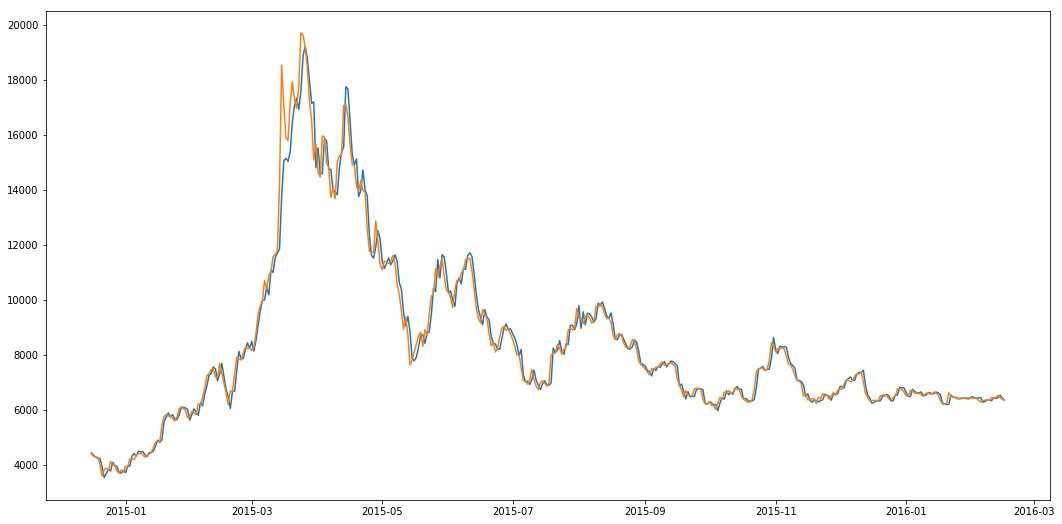

In [14]:
time, pred, true = model.get_pred_test_pair()
plt.plot(time, pred)
plt.plot(time, true)

In [15]:
model.get_test_mae()

252.3711511547056

In [16]:
model.get_train_mae()

18.685321597174156

### 4 Steps Ahead prediction

In [17]:
OUT_TIMESTEPS = 4

model = LSTM_model(
    in_timesteps=IN_TIMESTEPS, out_timesteps=OUT_TIMESTEPS,
    x_cols=X_cols, y_cols=Y_cols, step_col="Date", train_ratio=TRAIN_RATIO, model = build_lstm_nn
).data(daily_info).fit(epochs=EPOCHS)

Epoch 1/1000
996/996 [==============================] - 1s 544us/step - loss: 0.1090
Epoch 2/1000
996/996 [==============================] - 0s 36us/step - loss: 0.1077
Epoch 3/1000
996/996 [==============================] - 0s 41us/step - loss: 0.1065
Epoch 4/1000
996/996 [==============================] - 0s 33us/step - loss: 0.1054
Epoch 5/1000
996/996 [==============================] - 0s 36us/step - loss: 0.1043
Epoch 6/1000
996/996 [==============================] - 0s 37us/step - loss: 0.1033
Epoch 7/1000
996/996 [==============================] - 0s 41us/step - loss: 0.1023
Epoch 8/1000
996/996 [==============================] - 0s 33us/step - loss: 0.1014
Epoch 9/1000
996/996 [==============================] - 0s 34us/step - loss: 0.1005
Epoch 10/1000
996/996 [==============================] - 0s 34us/step - loss: 0.0996
Epoch 11/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0987
Epoch 12/1000
996/996 [==============================] - 0s 29us/step - l

996/996 [==============================] - 0s 30us/step - loss: 0.0498
Epoch 98/1000
996/996 [==============================] - 0s 34us/step - loss: 0.0497
Epoch 99/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0496
Epoch 100/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0495
Epoch 101/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0493
Epoch 102/1000
996/996 [==============================] - 0s 37us/step - loss: 0.0492
Epoch 103/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0491
Epoch 104/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0490
Epoch 105/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0489
Epoch 106/1000
996/996 [==============================] - 0s 37us/step - loss: 0.0488
Epoch 107/1000
996/996 [==============================] - 0s 38us/step - loss: 0.0487
Epoch 108/1000
996/996 [==============================] - 0s 34us/step 

996/996 [==============================] - 0s 32us/step - loss: 0.0434
Epoch 193/1000
996/996 [==============================] - 0s 37us/step - loss: 0.0433
Epoch 194/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0433
Epoch 195/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0432
Epoch 196/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0432
Epoch 197/1000
996/996 [==============================] - 0s 35us/step - loss: 0.0432
Epoch 198/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0431
Epoch 199/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0431
Epoch 200/1000
996/996 [==============================] - 0s 38us/step - loss: 0.0430
Epoch 201/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0430
Epoch 202/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0430
Epoch 203/1000
996/996 [==============================] - 0s 31us/ste

996/996 [==============================] - 0s 37us/step - loss: 0.0403
Epoch 288/1000
996/996 [==============================] - 0s 36us/step - loss: 0.0403
Epoch 289/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0402
Epoch 290/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0402
Epoch 291/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0402
Epoch 292/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0401
Epoch 293/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0401
Epoch 294/1000
996/996 [==============================] - 0s 34us/step - loss: 0.0401
Epoch 295/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0401
Epoch 296/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0400
Epoch 297/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0400
Epoch 298/1000
996/996 [==============================] - 0s 32us/ste

996/996 [==============================] - 0s 31us/step - loss: 0.0382
Epoch 383/1000
996/996 [==============================] - 0s 35us/step - loss: 0.0382
Epoch 384/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0382
Epoch 385/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0382
Epoch 386/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0382
Epoch 387/1000
996/996 [==============================] - 0s 36us/step - loss: 0.0381
Epoch 388/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0381
Epoch 389/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0381
Epoch 390/1000
996/996 [==============================] - 0s 39us/step - loss: 0.0381
Epoch 391/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0381
Epoch 392/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0381
Epoch 393/1000
996/996 [==============================] - 0s 59us/ste

996/996 [==============================] - 0s 33us/step - loss: 0.0368
Epoch 478/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0368
Epoch 479/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0368
Epoch 480/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0368
Epoch 481/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0368
Epoch 482/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0368
Epoch 483/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0367
Epoch 484/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0367
Epoch 485/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0367
Epoch 486/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0367
Epoch 487/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0367
Epoch 488/1000
996/996 [==============================] - 0s 31us/ste

996/996 [==============================] - 0s 36us/step - loss: 0.0357
Epoch 573/1000
996/996 [==============================] - 0s 36us/step - loss: 0.0357
Epoch 574/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0357
Epoch 575/1000
996/996 [==============================] - 0s 34us/step - loss: 0.0357
Epoch 576/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0357
Epoch 577/1000
996/996 [==============================] - 0s 37us/step - loss: 0.0357
Epoch 578/1000
996/996 [==============================] - 0s 36us/step - loss: 0.0357
Epoch 579/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0357
Epoch 580/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0357
Epoch 581/1000
996/996 [==============================] - 0s 28us/step - loss: 0.0357
Epoch 582/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0356
Epoch 583/1000
996/996 [==============================] - 0s 30us/ste

996/996 [==============================] - 0s 36us/step - loss: 0.0350
Epoch 668/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0350
Epoch 669/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0350
Epoch 670/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0350
Epoch 671/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0350
Epoch 672/1000
996/996 [==============================] - 0s 29us/step - loss: 0.0350
Epoch 673/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0350
Epoch 674/1000
996/996 [==============================] - 0s 55us/step - loss: 0.0350
Epoch 675/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0350
Epoch 676/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0350
Epoch 677/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0349
Epoch 678/1000
996/996 [==============================] - 0s 31us/ste

996/996 [==============================] - 0s 34us/step - loss: 0.0345
Epoch 763/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0345
Epoch 764/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0345
Epoch 765/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0345
Epoch 766/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0345
Epoch 767/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0345
Epoch 768/1000
996/996 [==============================] - 0s 34us/step - loss: 0.0345
Epoch 769/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0345
Epoch 770/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0345
Epoch 771/1000
996/996 [==============================] - 0s 26us/step - loss: 0.0345
Epoch 772/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0345
Epoch 773/1000
996/996 [==============================] - 0s 35us/ste

996/996 [==============================] - 0s 35us/step - loss: 0.0343
Epoch 858/1000
996/996 [==============================] - 0s 35us/step - loss: 0.0343
Epoch 859/1000
996/996 [==============================] - 0s 35us/step - loss: 0.0343
Epoch 860/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0342
Epoch 861/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0342
Epoch 862/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0342
Epoch 863/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0342
Epoch 864/1000
996/996 [==============================] - 0s 34us/step - loss: 0.0342
Epoch 865/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0342
Epoch 866/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0342
Epoch 867/1000
996/996 [==============================] - 0s 44us/step - loss: 0.0342
Epoch 868/1000
996/996 [==============================] - 0s 32us/ste

996/996 [==============================] - 0s 35us/step - loss: 0.0341
Epoch 953/1000
996/996 [==============================] - 0s 34us/step - loss: 0.0341
Epoch 954/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0341
Epoch 955/1000
996/996 [==============================] - 0s 33us/step - loss: 0.0341
Epoch 956/1000
996/996 [==============================] - 0s 27us/step - loss: 0.0341
Epoch 957/1000
996/996 [==============================] - 0s 34us/step - loss: 0.0341
Epoch 958/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0341
Epoch 959/1000
996/996 [==============================] - 0s 32us/step - loss: 0.0341
Epoch 960/1000
996/996 [==============================] - 0s 34us/step - loss: 0.0341
Epoch 961/1000
996/996 [==============================] - 0s 31us/step - loss: 0.0341
Epoch 962/1000
996/996 [==============================] - 0s 30us/step - loss: 0.0341
Epoch 963/1000
996/996 [==============================] - 0s 31us/ste

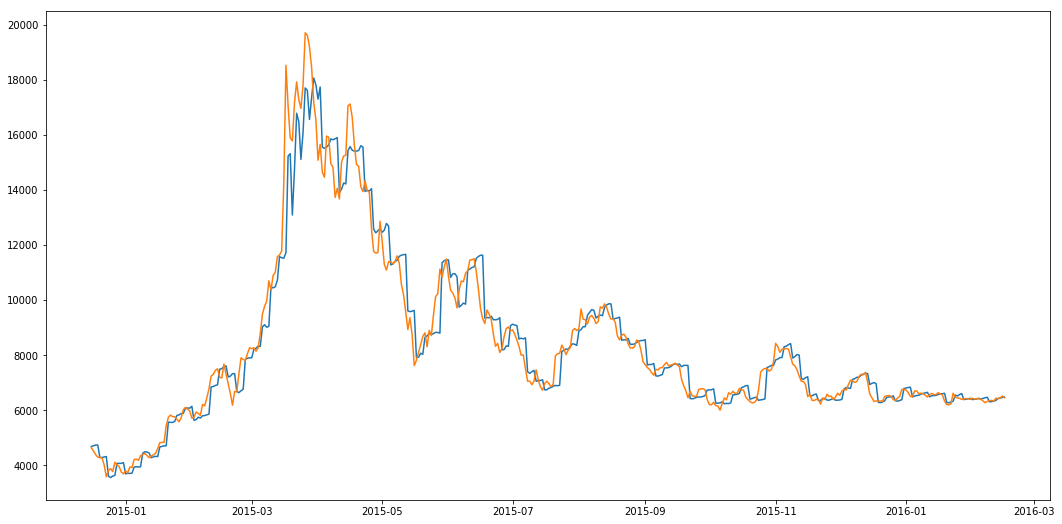

In [18]:
time, pred, true = model.get_pred_test_pair()
plt.plot(time, pred)
plt.plot(time, true)

In [19]:
model.get_test_mae(), model.get_train_mae()

(439.9190518359032, 31.549084034704492)